# Exploitation

This section implements pure exploitation process where the next infill point is obtained by minimizing the surrogate model. Below code imports required packages, defines forrester function, and defines training and plotting data:

In [45]:
# Imports
import numpy as np
from scipy.optimize import differential_evolution
from smt.surrogate_models import KRG
import matplotlib.pyplot as plt

# Function
forrester = lambda x: (6*x-2)**2*np.sin(12*x-4)

# Training data
xtrain = np.linspace(0, 1, 5)
ytrain = forrester(xtrain)

# Plotting data
xplot = np.linspace(0, 1, 100)
yplot = forrester(xplot)

Iteration 1
[5.]
Error: [0.17403776]
f*: [-5.34481565]
x*: [0.71928109]
Iteration 2
[5.]
Error: [0.17719376]
f*: [-5.32446949]
x*: [0.71866644]
Iteration 3
[5.]
Error: [0.17281097]
f*: [-5.35264655]
x*: [0.71951964]
Iteration 4
[5.]
Error: [0.18363771]
f*: [-5.28203841]
x*: [0.71740718]
Iteration 5
[5.]
Error: [0.17539603]
f*: [-5.3360945]
x*: [0.71901673]
Iteration 6
[5.]
Error: [0.17602559]
f*: [-5.33203411]
x*: [0.71889411]
Iteration 7
[5.]
Error: [0.1762636]
f*: [-5.33049601]
x*: [0.71884774]
Iteration 8
[5.]
Error: [0.1741476]
f*: [-5.34411243]
x*: [0.71925973]
Iteration 9
[5.]
Error: [0.17186981]
f*: [-5.35862439]
x*: [0.7197025]
Iteration 10
[5.]
Error: [0.18072156]
f*: [-5.30138694]
x*: [0.71797774]


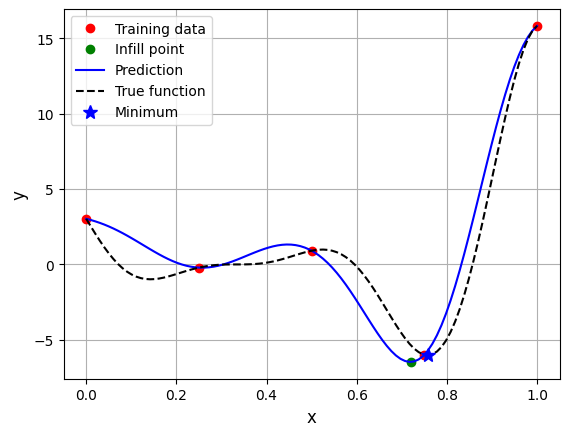

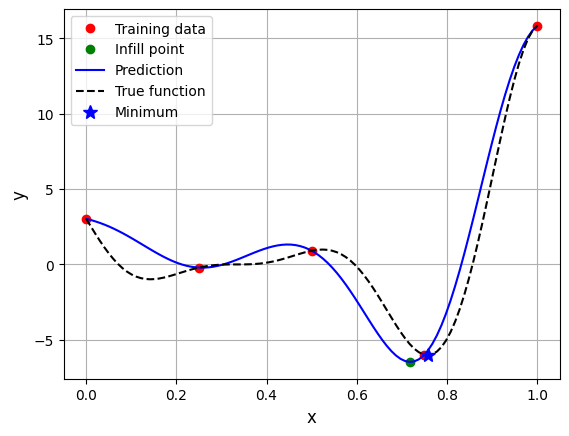

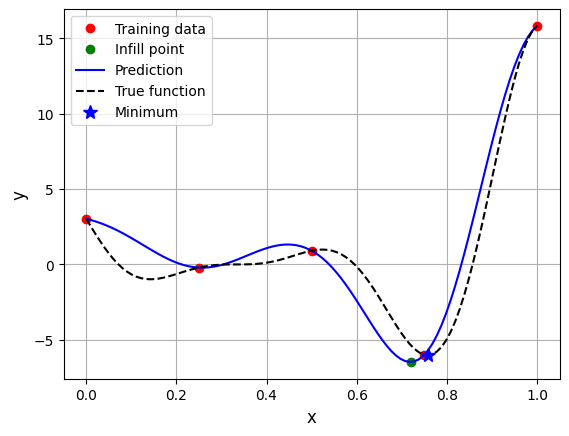

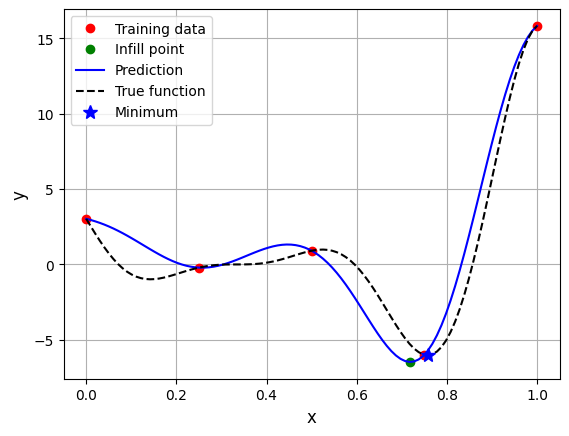

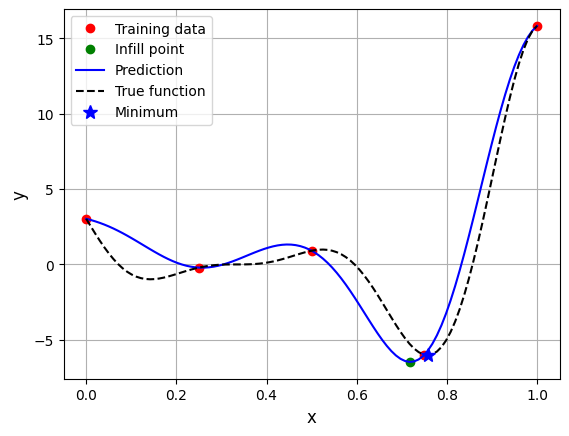

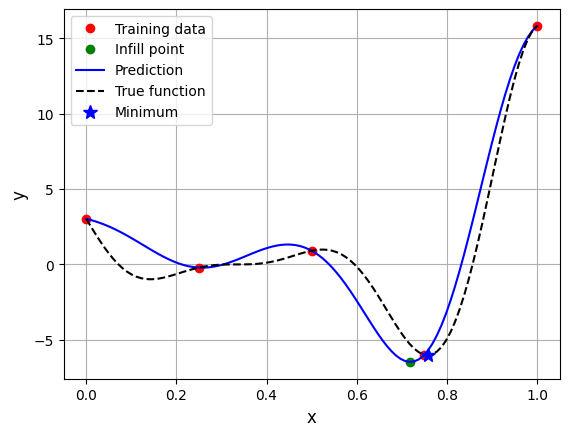

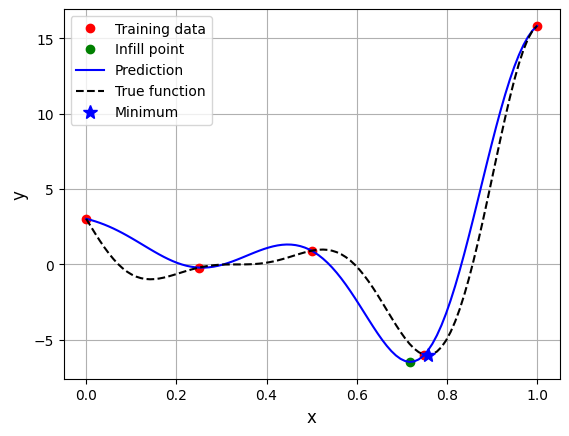

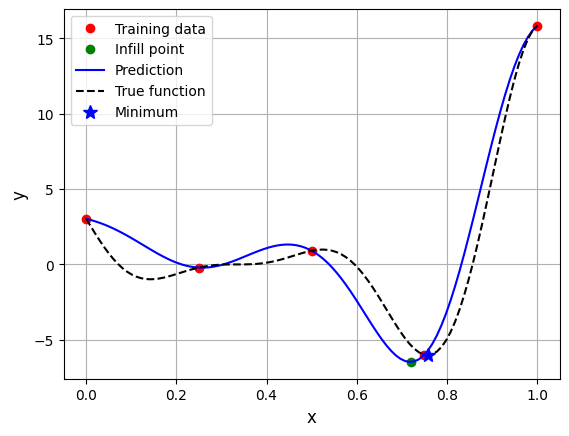

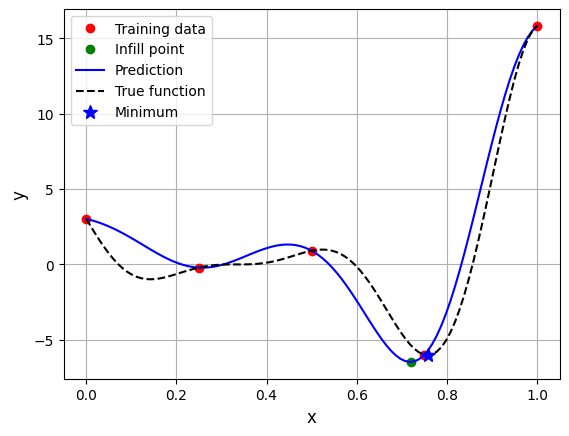

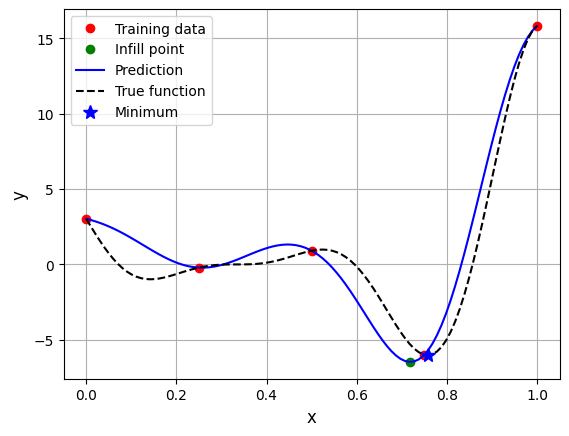

In [46]:
# Variables
itr = 0
max_itr = 10
tol = 1e-3
error = 1
criteria = []
bounds = [(0, 1)]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < error:
    
    print("Iteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 5], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    print(sm.optimal_theta)

    # Find the minimum of surrogate model
    result = differential_evolution(func=lambda x: sm.predict_values(x.reshape(1,-1))[0][0], 
                                    disp=False, bounds=bounds, polish=False)
    
    # Computing true function value at infill point
    y_infill = forrester(result.x)
    
    # Comuting error
    error = np.abs(result.fun - y_infill)/np.abs(result.fun)
    criteria.append(error)

    print("Error: {}".format(error))

    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.x))

    fig, ax = plt.subplots()
    ax.plot(xtrain, ytrain, "ro", label="Training data")
    ax.plot(result.x, result.fun, "go", label="Infill point")
    ax.plot(xplot, sm.predict_values(xplot.reshape(-1,1)).reshape(-1,), "b", label="Prediction")
    ax.plot(xplot, yplot, "k--", label="True function")
    ax.plot(xplot[np.argmin(yplot)], np.min(yplot), "b*", label="Minimum", markersize=10)
    ax.set_xlabel("x", fontsize=fs)
    ax.set_ylabel("y", fontsize=fs)
    ax.grid()
    ax.legend(fontsize=fs-2)
    
    # Appending the the new point to the current data set
    x_train = np.append( xtrain, result.x )
    y_train = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number